In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from colormath.color_objects import LabColor, sRGBColor
from colormath.color_conversions import convert_color
from scipy.optimize import minimize, show_options
import matplotlib as mpl
import tikzplotlib
from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
import math

mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 1
plt.rcParams['grid.color'] = "#cccccc"
plt.rc('axes', axisbelow=True)
plt.rc('font', size=17)
plt.rc('text', usetex=True)

%matplotlib notebook

In [2]:
df = pd.read_csv("../power_data/helsinki1.csv")[['currentNow', 'R', 'G', 'B']]

In [3]:
R = []
yR = []
G = []
yG = []
B = []
yB = []
LAB = []
LAB_power = []

for index, row in df.iterrows():
    if row['B'] != 0:
        B.append(row['B'])
        yB.append(-row['currentNow'])
    if row['G'] != 0:
        G.append(row['G'])
        yG.append(-row['currentNow'])
    if row['R'] != 0:
        R.append(row['R'])
        yR.append(-row['currentNow'])
    LAB.append(convert_color(sRGBColor(row['R']/255, row['G']/255, row['B']/255), LabColor).get_value_tuple())
    LAB_power.append(-row['currentNow'])

<IPython.core.display.Javascript object>


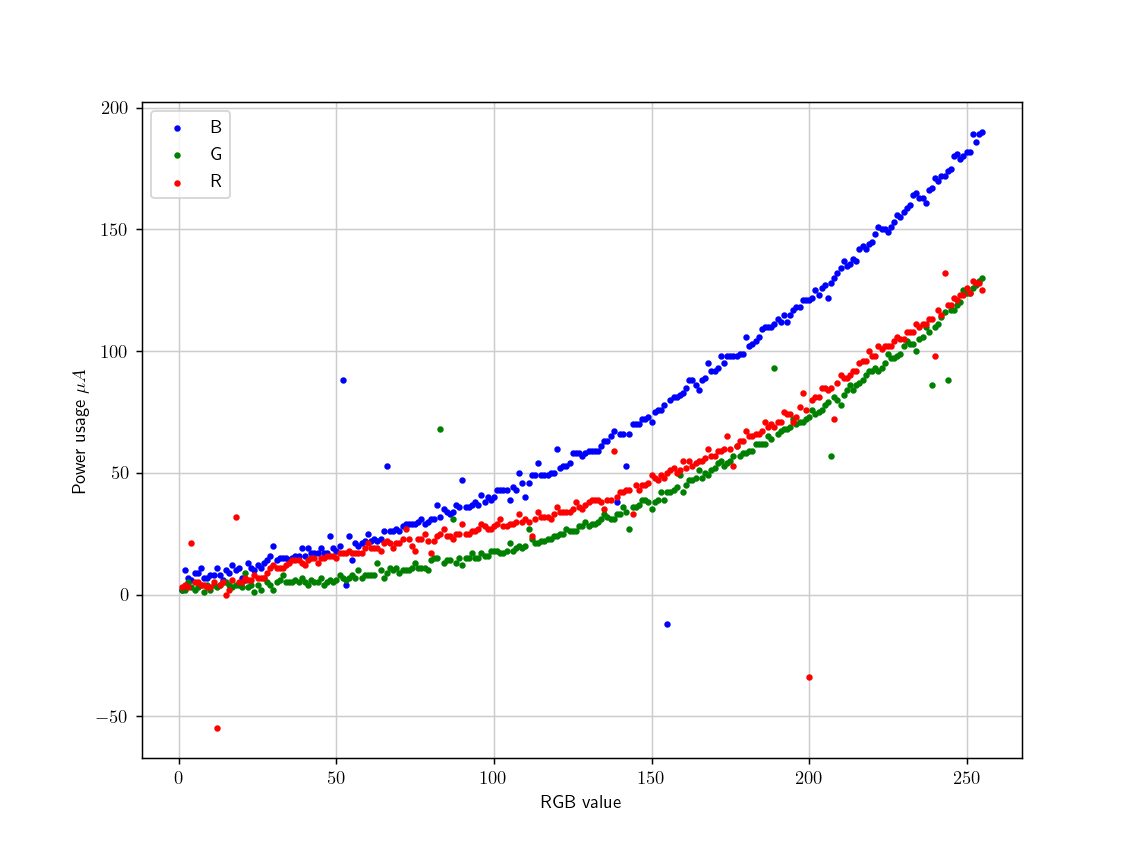

Text(0, 0.5, 'Power usage $\\mu A$')

In [4]:
fig=plt.figure()
plt.scatter(B, yB, c='blue', label="B", s=6)
plt.scatter(G, yG, c='green', label="G", s=6)
plt.scatter(R, yR, c='red', label="R", s=6)
plt.legend()
plt.xlabel("RGB value")
plt.ylabel("Power usage $\mu A$")

In [9]:
tikzplotlib.save("points.tex")

In [6]:
a = np.polyfit(R, yR, 2)

In [7]:
a

array([ 1.81327648e-03, -4.30198100e-03,  8.32619479e+00])

In [12]:
pts = np.array([np.array(R)**3, np.array(R)**2, np.array(R)]).T
r = LinearRegression()
r.fit(pts, yR)
r.coef_, r.intercept_

(array([ 9.33773772e-06, -1.77241480e-03,  3.63591812e-01]),
 0.40109990900690207)

In [13]:
pts = np.array([np.array(G)**3, np.array(G)**2, np.array(G)]).T
g = LinearRegression()
g.fit(pts, yG)
g.coef_, g.intercept_

(array([3.31277854e-06, 9.59555435e-04, 2.57421833e-02]), 2.9828252112477784)

In [14]:
pts = np.array([np.array(B)**3, np.array(B)**2, np.array(B)]).T
b = LinearRegression()
b.fit(pts, yB)
b.coef_, b.intercept_

(array([4.19953259e-06, 9.91716987e-04, 1.99992989e-01]), 7.100178049693497)

<IPython.core.display.Javascript object>


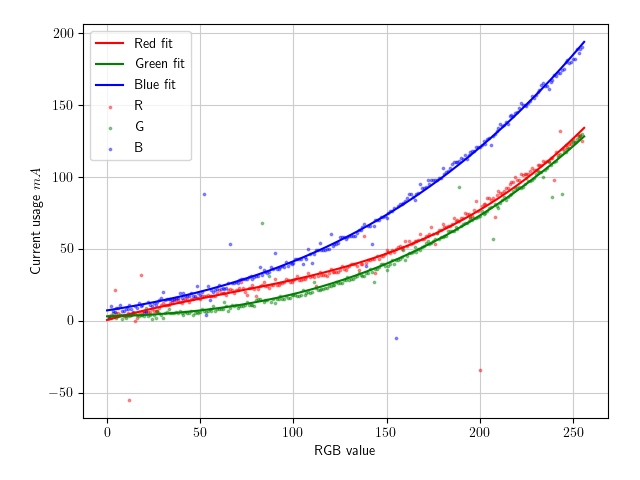

In [15]:
fig=plt.figure()
plt.scatter(R, yR, c='red', label="R", s=3, alpha=0.4)
plt.scatter(G, yG, c='green', label="G", s=3, alpha=0.4)
plt.scatter(B, yB, c='blue', label="B", s=3, alpha=0.4)
x = np.linspace(0, 256, 1000)
plt.plot(x, r.predict(np.array([np.array(x)**3, np.array(x)**2, np.array(x)]).T), color="red", label="Red fit")
plt.plot(x, g.predict(np.array([np.array(x)**3, np.array(x)**2, np.array(x)]).T), color="green", label="Green fit")
plt.plot(x, b.predict(np.array([np.array(x)**3, np.array(x)**2, np.array(x)]).T), color="blue", label="Blue fit")
plt.legend()
fig.subplots_adjust(bottom=0.13, left=0.13, right=0.95, top=0.95)
plt.xlabel("RGB value")
plt.ylabel("Current usage $mA$")
plt.savefig("points.pdf")

In [7]:
fig=plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.set_xlabel('a')
ax.set_ylabel('b')
ax.set_zlabel('L')

L = np.array(LAB)[:, 0]
a = np.array(LAB)[:, 1]
b = np.array(LAB)[:, 2]

img = ax.scatter(a, b, L, c=(LAB_power-model(L, a, b, x)), cmap=plt.hot(), vmin=0, vmax=10)
plt.title("Absolute error of the power model in the CIELAB space")
fig.colorbar(img)
plt.show()

<IPython.core.display.Javascript object>

NameError: name 'model' is not defined

<IPython.core.display.Javascript object>


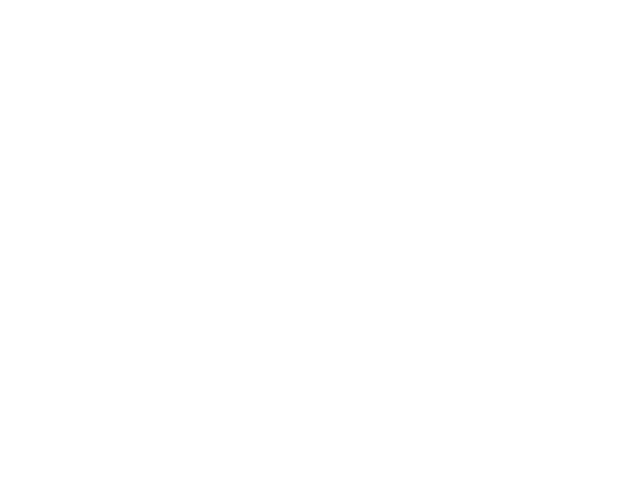

NameError: name 'model' is not defined

In [8]:
fig=plt.figure()
plt.hist(np.absolute(LAB_power-model(L, a, b, x)), 100, (0, 20))
plt.xlabel("Absolute error")
plt.ylabel("Number of occurances")
plt.title("Absolute error of the power model in the CIELAB space")
plt.show()
errors = (LAB_power-model(L, a, b, x))/np.array(LAB_power)
errors = np.where( np.absolute(errors) <= 0.5, errors, 0.5)
print(np.mean(np.absolute(LAB_power-model(L, a, b, x))))
print(np.std(LAB_power/model(L, a, b, x)))

# Problem statement for fitting

We pose the problem as fitting the following function (the matrix $D_\alpha$ in the Crayon paper) $xL^2+ya^2+zb^2+2qLa+2hLb+2kab$ to the data itself by minimizing the residual in the form of sum of squared error values.

In [388]:
def model(L, a, b, x):
    return x[0]*L**2 + x[1]*a**2 + x[2]*b**2 + 2*x[3]*L*a + 2*x[4]*L*b + 2*x[5]*a*b + x[6]#*L + x[7]*a + x[8]*b + x[6]

In [10]:
def cost(x):
    L = np.array(LAB)[:, 0]
    a = np.array(LAB)[:, 1]
    b = np.array(LAB)[:, 2]
    
    return np.sqrt(np.sum((model(L, a, b, x) - LAB_power)**2))

In [11]:
def grad(x):
    L = np.array(LAB)[:, 0]
    a = np.array(LAB)[:, 1]
    b = np.array(LAB)[:, 2]
    
    return np.array([np.sum((model(L, a, b, x) - LAB_power)*L**2),
            np.sum((model(L, a, b, x) - LAB_power)*a**2),
            np.sum((model(L, a, b, x) - LAB_power)*b**2),
            np.sum((model(L, a, b, x) - LAB_power)*2*L*a),
            np.sum((model(L, a, b, x) - LAB_power)*2*L*b),
            np.sum((model(L, a, b, x) - LAB_power)*2*a*b),
            np.sum((model(L, a, b, x) - LAB_power)*np.ones(a.shape))])/cost(x)

In [12]:
minimize(cost, np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), jac=grad)

ValueError: shapes (10,10) and (7,) not aligned: 10 (dim 1) != 7 (dim 0)

# Accuracy of the model

We check the accuracy by generating random points that are just the linear combination of the bases defined above.

In [398]:
N = 100000

R = np.random.randint(0, 256, N)
G = np.random.randint(0, 256, N)
B = np.random.randint(0, 256, N)

modelTestPoints = []
modelTestPower = []
realPower = []

for i in range(N):
    power = 0
    power -= float(df.loc[(df['R']==R[i]) & (df['G']==0) & (df['B']==0)]['currentNow']) if R[i] != 0 else 0
    power -= float(df.loc[(df['R']==0) & (df['G']==G[i]) & (df['B']==0)]['currentNow']) if G[i] != 0 else 0
    power -= float(df.loc[(df['R']==0) & (df['G']==0) & (df['B']==B[i])]['currentNow']) if B[i] != 0 else 0
    realPower.append(power)
    
    modelTestPoints.append(convert_color(sRGBColor(R[i]/255, G[i]/255, B[i]/255), LabColor).get_value_tuple())


<IPython.core.display.Javascript object>


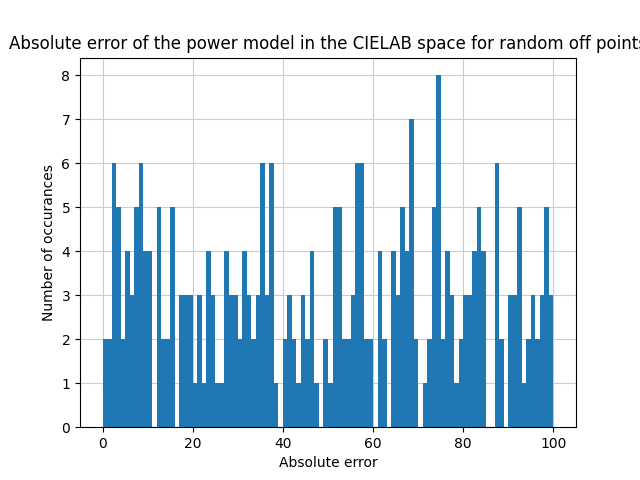

-795.7905626740461
44.90312563301509


In [16]:
plt.figure()
plt.hist(np.absolute(np.array(realPower)-np.array(modelTestPower)), 100, (0, 100))
plt.xlabel("Absolute error")
plt.ylabel("Number of occurances")
plt.title("Absolute error of the power model in the CIELAB space for random off points")
plt.show()

print(np.mean(np.array(realPower)-np.array(modelTestPower)))
print(np.std(LAB_power))

# Improving accuracy of the model

In [399]:
def new_cost(x):
    L = np.concatenate((np.array(LAB)[:, 0], np.array(modelTestPoints)[:, 0]))
    a = np.concatenate((np.array(LAB)[:, 1], np.array(modelTestPoints)[:, 1]))
    b = np.concatenate((np.array(LAB)[:, 2], np.array(modelTestPoints)[:, 2]))
    
    return np.sqrt(np.sum((model(L, a, b, x) - np.concatenate((np.array(LAB_power), np.array(realPower))))**2))

In [400]:
def new_grad(x):
    L = np.concatenate((np.array(LAB)[:, 0], np.array(modelTestPoints)[:, 0]))
    a = np.concatenate((np.array(LAB)[:, 1], np.array(modelTestPoints)[:, 1]))
    b = np.concatenate((np.array(LAB)[:, 2], np.array(modelTestPoints)[:, 2]))
    
    return np.array([np.sum((model(L, a, b, x) - np.concatenate((np.array(LAB_power), np.array(realPower))))*L**2),
            np.sum((model(L, a, b, x) - np.concatenate((np.array(LAB_power), np.array(realPower))))*a**2),
            np.sum((model(L, a, b, x) - np.concatenate((np.array(LAB_power), np.array(realPower))))*b**2),
            np.sum((model(L, a, b, x) - np.concatenate((np.array(LAB_power), np.array(realPower))))*2*L*a),
            np.sum((model(L, a, b, x) - np.concatenate((np.array(LAB_power), np.array(realPower))))*2*L*b),
            np.sum((model(L, a, b, x) - np.concatenate((np.array(LAB_power), np.array(realPower))))*2*a*b),
#             np.sum((model(L, a, b, x) - np.concatenate((np.array(LAB_power), np.array(realPower))))*L),
#             np.sum((model(L, a, b, x) - np.concatenate((np.array(LAB_power), np.array(realPower))))*a),
#             np.sum((model(L, a, b, x) - np.concatenate((np.array(LAB_power), np.array(realPower))))*b),
            np.sum((model(L, a, b, x) - np.concatenate((np.array(LAB_power), np.array(realPower))))*np.ones(a.shape))])/new_cost(x)

In [401]:
minimize(new_cost, np.array([1, 1, 1, 1, 1, 1, 1]), jac=new_grad)

      fun: 4409.023184148045
 hess_inv: array([[ 1.41015413e-08, -8.14528475e-10,  3.18220594e-10,
         2.27183346e-09, -2.04239807e-09, -1.52830014e-10,
        -4.84616142e-05],
       [-8.14528475e-10,  2.07806896e-08,  4.58378533e-09,
        -3.67494438e-09, -2.40125531e-09,  8.00654463e-09,
        -2.70511855e-05],
       [ 3.18220594e-10,  4.58378533e-09,  2.37211899e-08,
        -4.04197577e-09, -4.51213714e-09,  1.04445391e-08,
        -3.02664670e-05],
       [ 2.27183346e-09, -3.67494438e-09, -4.04197577e-09,
         4.22222898e-09,  2.37534958e-09, -3.48820446e-09,
        -3.09864150e-06],
       [-2.04239807e-09, -2.40125531e-09, -4.51213714e-09,
         2.37534958e-09,  3.90654564e-09, -3.17113890e-09,
         9.78144370e-06],
       [-1.52830014e-10,  8.00654463e-09,  1.04445391e-08,
        -3.48820446e-09, -3.17113890e-09,  9.50791801e-09,
        -1.19171567e-05],
       [-4.84616142e-05, -2.70511855e-05, -3.02664670e-05,
        -3.09864150e-06,  9.78144370e

In [97]:
new_x = [ 4.49205614e-02,  1.33997328e-04,  3.74241845e-03,  6.13043766e-03,
       -8.25940869e-03, -4.05173384e-04, -4.83234388e-01,  1.73410120e-02,
       -4.57018167e-03,  2.27882606e+01]

In [98]:
N = 10000

R = np.random.randint(0, 256, N)
G = np.random.randint(0, 256, N)
B = np.random.randint(0, 256, N)

In [99]:
modelTestPoints = []
modelTestPower = []
realPower = []

for i in range(N):
    power = 0
    power -= float(df.loc[(df['R']==R[i]) & (df['G']==0) & (df['B']==0)]['currentNow']) if R[i] != 0 else 0
    power -= float(df.loc[(df['R']==0) & (df['G']==G[i]) & (df['B']==0)]['currentNow']) if G[i] != 0 else 0
    power -= float(df.loc[(df['R']==0) & (df['G']==0) & (df['B']==B[i])]['currentNow']) if B[i] != 0 else 0
    realPower.append(power)
                               
    modelTestPoints.append(convert_color(sRGBColor(R[i]/255, G[i]/255, B[i]/255), LabColor).get_value_tuple())
    modelTestPower.append(model(modelTestPoints[-1][0], modelTestPoints[-1][1], modelTestPoints[-1][2], new_x))

<IPython.core.display.Javascript object>


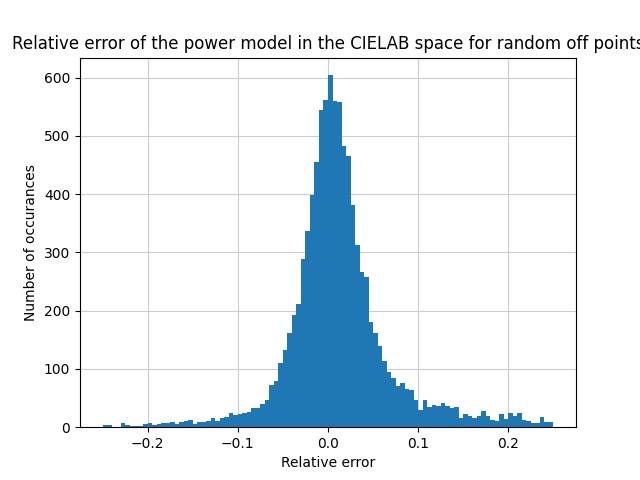

0.07951561611624483
44.90312563301509


In [100]:
plt.figure()
plt.hist((np.array(realPower)-np.array(modelTestPower))/np.array(realPower), 100, (-0.25, 0.25))
plt.xlabel("Relative error")
plt.ylabel("Number of occurances")
plt.title("Relative error of the power model in the CIELAB space for random off points")
plt.show()

print(np.mean(np.absolute(np.array(realPower)-np.array(modelTestPower))/np.array(realPower)))
print(np.std(LAB_power))

In [27]:
tikzplotlib.save("relative_errors_with_linear.tex")

In [28]:
D = np.array([[new_x[0], new_x[3], new_x[4]], [new_x[3], new_x[1], new_x[5]], [new_x[4], new_x[5], new_x[2]]])

In [434]:
np.linalg.eig(D)

(array([0.20132436, 0.06063921, 0.01164639]),
 array([[ 0.99776049,  0.05867205, -0.03211856],
        [ 0.03227463, -0.00171409,  0.99947757],
        [-0.05858635,  0.99827584,  0.00360387]]))

# Final version

In [488]:
N = 100000

R = np.random.randint(0, 256, N)
G = np.random.randint(0, 256, N)
B = np.random.randint(0, 256, N)

modelTrainPoints = []
realPower = []

for i in range(N):
    power = 0
    power -= float(df.loc[(df['R']==R[i]) & (df['G']==0) & (df['B']==0)]['currentNow']) if R[i] != 0 else 0 #r.predict([[R[i]**3, R[i]**2, R[i]]])
    power -= float(df.loc[(df['R']==0) & (df['G']==G[i]) & (df['B']==0)]['currentNow']) if G[i] != 0 else 0 #g.predict([[G[i]**3, G[i]**2, G[i]]])
    power -= float(df.loc[(df['R']==0) & (df['G']==0) & (df['B']==B[i])]['currentNow']) if B[i] != 0 else 0 #b.predict([[B[i]**3, B[i]**2, B[i]]])
    realTestPower.append(power)
    realPower.append(power)
    modelTrainPoints.append(convert_color(sRGBColor(R[i]/255, G[i]/255, B[i]/255), LabColor).get_value_tuple())

In [489]:
def model(L, a, b, x):
    return x[0]*L**2 + x[1]*a**2 + x[2]*b**2 + 2*x[3]*L*a + 2*x[4]*L*b + 2*x[5]*a*b + x[6]*L + x[7]*a + x[8]*b + x[9]

In [490]:
def cost(x):
    L = np.array(modelTrainPoints)[:, 0]
    a = np.array(modelTrainPoints)[:, 1]
    b = np.array(modelTrainPoints)[:, 2]
    
    return np.sum((model(L, a, b, x) - np.array(realPower))**2)

In [491]:
def grad(x):
    L = np.array(modelTrainPoints)[:, 0]
    a = np.array(modelTrainPoints)[:, 1]
    b = np.array(modelTrainPoints)[:, 2]
    
    return 2*np.array([np.sum((model(L, a, b, x) - np.array(realPower))*L**2),
            np.sum((model(L, a, b, x) - np.array(realPower))*a**2),
            np.sum((model(L, a, b, x) - np.array(realPower))*b**2),
            np.sum((model(L, a, b, x) - np.array(realPower))*2*L*a),
            np.sum((model(L, a, b, x) - np.array(realPower))*2*L*b),
            np.sum((model(L, a, b, x) - np.array(realPower))*2*a*b),
            np.sum((model(L, a, b, x) - np.array(realPower))*L),
            np.sum((model(L, a, b, x) - np.array(realPower))*a),
            np.sum((model(L, a, b, x) - np.array(realPower))*b),
            np.sum((model(L, a, b, x) - np.array(realPower))*np.ones(a.shape))])

In [492]:
x = minimize(cost, np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), jac=grad)['x']

In [493]:
x

array([ 5.12040476e-02,  1.08748289e-03,  4.61453920e-03,  7.12853167e-03,
       -9.22189345e-03, -2.55714768e-04, -1.25929564e+00, -1.25505864e-01,
        1.09027499e-01,  4.35157035e+01])

# Test other options

In [583]:
L = np.array(modelTrainPoints)[:, 0]
a = np.array(modelTrainPoints)[:, 1]
b = np.array(modelTrainPoints)[:, 2]

x_train = np.array([L**3, a**3, b**3, L**2*a, L**2*b, a**2*L, a**2*b, b**2*L, b**2*a, L**2, a**2, b**2, 2*L*a, 2*L*b, 2*a*b, L, a, b]).T

In [584]:
x_train.shape

(100000, 18)

In [585]:
model = LinearRegression()
model.fit(x_train, realPower)

LinearRegression()

In [579]:
model.coef_

array([ 2.77244186e-02, -1.82782644e-03, -9.42912491e-04,  1.31308946e+00,
        7.69455609e-01, -8.89717337e-01])

In [580]:
model.intercept_

-15.419999330850573

In [499]:
N = 10000

R = np.random.randint(0, 256, N)
G = np.random.randint(0, 256, N)
B = np.random.randint(0, 256, N)

In [586]:
modelTestPower = []
modelTestPoints = []
realTestPower = []

for i in range(N):
    power = 0
    power -= float(df.loc[(df['R']==R[i]) & (df['G']==0) & (df['B']==0)]['currentNow']) if R[i] != 0 else 0 #r.predict([[R[i]**3, R[i]**2, R[i]]])
    power -= float(df.loc[(df['R']==0) & (df['G']==G[i]) & (df['B']==0)]['currentNow']) if G[i] != 0 else 0 #g.predict([[G[i]**3, G[i]**2, G[i]]])
    power -= float(df.loc[(df['R']==0) & (df['G']==0) & (df['B']==B[i])]['currentNow']) if B[i] != 0 else 0 #b.predict([[B[i]**3, B[i]**2, B[i]]])
    realTestPower.append(power)
    L, a, bz = convert_color(sRGBColor(R[i]/255, G[i]/255, B[i]/255), LabColor).get_value_tuple()
    modelTestPoints.append([L**3, a**3, bz**3, L**2*a, L**2*bz, a**2*L, a**2*bz, bz**2*L, bz**2*a, L**2, a**2, bz**2, 2*L*a, 2*L*bz, 2*a*bz, L, a, bz])#
    #modelTestPower.append(model(L, a, b, x))
    
modelTestPower = model.predict(np.array(modelTestPoints))

<IPython.core.display.Javascript object>


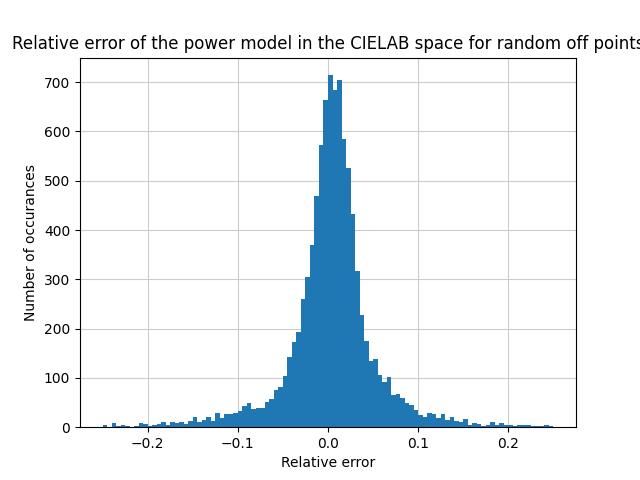

5.640570537442469
12.632484893247188
0.9705486746894765
0.9705518208931039


In [587]:
plt.figure()
plt.hist(relative, 100, (-0.25, 0.25))
plt.xlabel("Relative error")
plt.ylabel("Number of occurances")
plt.title("Relative error of the power model in the CIELAB space for random off points")
plt.show()

print(mean_absolute_error(realTestPower, modelTestPower))
print(math.sqrt(mean_squared_error(realTestPower, modelTestPower)))
print(r2_score(realTestPower, modelTestPower))
print(explained_variance_score(realTestPower, modelTestPower))

In [ ]:
7.131070314153795
13.926961686726077
0.9647387122688615
0.9647541826120491

In [ ]:
6.149707598394692
13.441969019874794
0.9671518294342288
0.9671623068504283

In [ ]:
6.149707598394679
13.441969019874792
0.9671518294342288
0.9671623068504283

In [ ]:
5.9251448470777
13.02073270263837
0.9693173157533435
0.9693173270687081

In [259]:
5.925144847077675
13.020732702638364
0.9693173157533435
0.9693173270687081

0.9693173270687081

In [241]:
5.520477057116418
12.908988479932328
0.9698416949205909
0.9699706372911983

0.9699706372911983

<IPython.core.display.Javascript object>


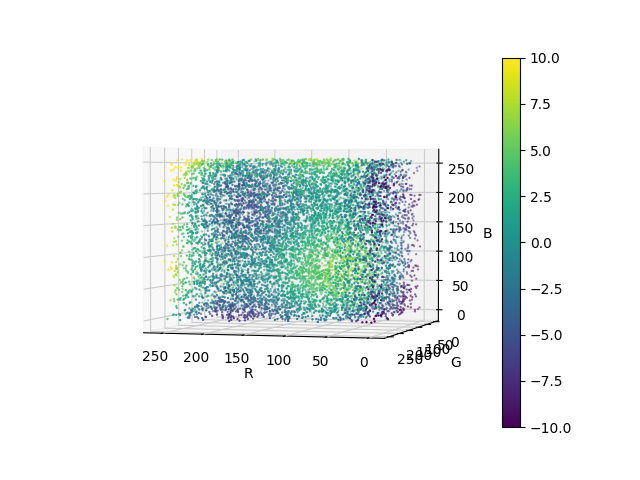

In [487]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#rgba_colors = np.zeros((10000,4))
#rgba_colors[:, 3] = (realTestPower-modelTestPower)/max()
img = ax.scatter(R, G, B, c=np.array(realTestPower)-modelTestPower, s=0.5, cmap=plt.viridis(), vmin=-10, vmax=10)
ax.set_xlabel('R')
ax.set_ylabel('G')
ax.set_zlabel('B')
fig.colorbar(img)

In [481]:
(np.array(realTestPower).T-modelTestPower).shape

(1, 10000)